# Word2Vec Embeddings - Using PySpark and PyArrow (distributed ML)

In [29]:
import numpy as np
import pandas as pd
import csv
import pickle
import time
import math
import collections
import os
from tqdm import tqdm

In [2]:
# !pip install pyspark
# !pip install -U -q PyDrive
# !sudo apt install openjdk-8-jdk-headless -qq
# !pip install pyarrow
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

openjdk-8-jdk-headless is already the newest version (8u282-b08-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 18 not upgraded.


In [2]:
import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

initialise spark context

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")
conf = (conf.setMaster('local[*]')
        .set('spark.executor.memory', '35G')
        .set('spark.driver.memory', '35G')
        .set('spark.driver.maxResultSize', '35G'))
# create the context
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled", "true")
# arrow enabling is what makes the conversion from pandas to spark dataframe really fast
sc._conf.get('spark.driver.memory')

'35G'

In [4]:
spark

# Step 1: No need to read in data if `CORPUS` is already saved (Skip to Step 2)

In [5]:
dirPath = '/home/ubuntu/Biomed-Data-Science-NLP-Project/Data/'
patientData_filepath = dirPath + 'B220_SAA_v1.csv'
CCSR_filepath = dirPath + 'ICD_to_CCSR_20201_1.csv'

In [6]:
def read_csv_to_dict(file_path: str, key: int, value: int):
    ret_dict = {}
    with open(file_path, newline='') as csvfile:
        data = csv.reader(csvfile, delimiter=',')
        for row in data:
            ret_dict[row[key][1:-1]] = row[value][1:-1] # "'icd_code'"
    print("Reading {} complete!".format(file_path))
    return ret_dict

In [7]:
icd_to_ccsr_code = read_csv_to_dict(CCSR_filepath, key=0, value=6) # 'icd_code' -> 'CCSR_code'
ccsr_codes = list(np.unique(list(icd_to_ccsr_code.values())))
ccsr_codes.remove('CCSR CATEGORY 1')

ccsr_code_to_index = collections.defaultdict(int)
for i, ccsr_code in enumerate(ccsr_codes):
    ccsr_code_to_index[ccsr_code] = i
    
print("{} CCSR categories".format(len(ccsr_code_to_index.keys())))

Reading /home/ubuntu/Biomed-Data-Science-NLP-Project/Data/ICD_to_CCSR_20201_1.csv complete!
519 CCSR categories


In [8]:
s1 = time.time()
icd_codes_table = pd.read_csv(patientData_filepath, usecols=range(16,41))
s2 = time.time()
print("Read data in {} minutes".format((s2-s1)/60))
corpus = [[elem for elem in row if type(elem) == str] for row in icd_codes_table.values.tolist()]
# corpus = [[icd1, icd2, icd3], [icd1, icd2],...]
s3 = time.time()
print("Corpus complete in {} minutes".format((s3-s1)/60))

Read data in 2.3586618741353353 minutes
Corpus complete in 6.171533286571503 minutes


In [9]:
len(corpus)

27977932

In [10]:
def sentenceToCCSR(sentence):
    ccsrSentence = ""
    for i, ICD_code in enumerate(sentence):
        if i==0:
            try:
                ccsr_code = str(icd_to_ccsr_code[ICD_code])
                ccsrSentence += ccsr_code
            except:
                pass
        else:
            try:
                ccsr_code = str(icd_to_ccsr_code[ICD_code])
                ccsrSentence += " " + ccsr_code
            except:
                pass
    return ccsrSentence

In [11]:
# Cycle through each sentence in corpus and generate stringed CCSR sentences
stringed_sentences = []
for s, inSentence in tqdm(enumerate(corpus)):
    sentence = sentenceToCCSR(inSentence) # ICD -> CCSR
    if sentence is not "":
        stringed_sentences.append(sentence)

27977932it [01:56, 240484.55it/s]


In [12]:
filename = dirPath + "stringed_CCSR_sentences.pkl"

uncomment this to save the file

In [13]:
# with open(filename, 'wb') as handle:
#     pickle.dump(stringed_sentences, handle)

# Step 2: Load the `CORPUS` of CCSR codes in patient visits

In [14]:
with open(filename, 'rb') as handle:
    stringed_sentences = pickle.load(handle)

In [15]:
corpus = icd_to_ccsr_code = icd_codes_table = ccsr_code_to_index  = ccsr_codes = None

## Create PySpark DataFrame from Pandas

In [16]:
tic = time.time()
df = pd.DataFrame(stringed_sentences, columns = ['sentences'])
toc = time.time()
print("time taken : {}s".format(toc - tic))
del stringed_sentences

# convert to Spark DF
sparkDF=spark.createDataFrame(df) 
print("time taken : {}s".format(time.time() - toc))
sparkDF.printSchema()
sparkDF.show()

time taken : 1.6443612575531006
time taken : 25.735881805419922
root
 |-- sentences: string (nullable = true)

+--------------------+
|           sentences|
+--------------------+
|INJ017 MUS011 INJ027|
|              GEN025|
|       MBD017 GEN004|
|CIR012 SYM013 MBD024|
|              GEN004|
|GEN009 NVS019 MUS...|
|              GEN004|
|       SYM004 MUS010|
|       MUS010 MUS010|
|MBD018 SYM004 NVS...|
|              INJ024|
|              DIG022|
|MUS011 NVS019 NVS016|
|MUS011 NVS019 NVS016|
|       NVS019 MUS010|
|NVS019 MUS038 NVS016|
|GEN016 FAC021 FAC021|
|NVS019 MUS038 MUS...|
|       NVS016 NVS019|
|SYM004 SYM006 SYM...|
+--------------------+
only showing top 20 rows



Cannot save spark dataframes as it is gives a ` can't pickle _thread.RLock objects` Typeerror. Because of parallelized implementation

## Tokenize the stringed CCSR sentences

In [39]:
from pyspark.ml.feature import Tokenizer
from pyspark.ml.feature import Word2Vec, Word2VecModel
from pyspark.ml import Pipeline

embed_size=100
tokenizer = Tokenizer(inputCol="sentences", outputCol="tokens")
tic = time.time()
tokenized = tokenizer.transform(sparkDF).select("tokens")
print("time taken : {}s".format(time.time() - tic))

time taken : 0.03626561164855957


Cannot save spark dataframes as it is gives a ` can't pickle _thread.RLock objects` Typeerror. Because of parallelized implementation

In [41]:
tokenized.show(3)
tokenized.count()

+--------------------+
|              tokens|
+--------------------+
|[inj017, mus011, ...|
|            [gen025]|
|    [mbd017, gen004]|
+--------------------+
only showing top 3 rows



27977932

## Look at the distribution of *number of CCSR codes in a sentence*
7 being the num chars occupied by a single CCSR code+space character

In [72]:
word_count = sparkDF.rdd.map(lambda x: (x, len(x.sentences)/7)) # 

In [73]:
wc = word_count.toDF(["sentence", "length"])

In [ ]:
# wc.show(20, truncate = False)

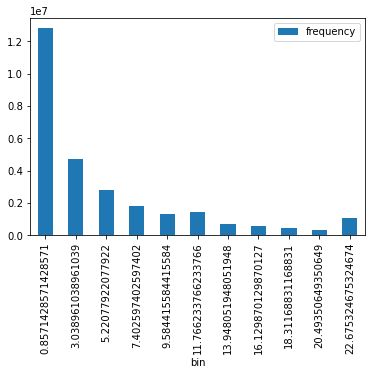

In [74]:
# Doing the heavy lifting in Spark. We could leverage the `histogram` function from the RDD api
wc_histogram = wc.select('length').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*wc_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

# Step 3: Train word2vec

In [24]:
w2v = Word2Vec(vectorSize=embed_size, minCount=1, inputCol="tokens", outputCol="features")\
            .setSeed(42).setWindowSize(2)
tic = time.time()
word2vec_model = w2v.fit(tokenized)
print("time taken : {}mins".format((time.time() - tic)/60))

time taken : 1816.4596192836761


default parameter for `window size` is 5. `minCount` is the minimum number of times a token must appear to be included in the word2vec model's vocabulary

In [26]:
word2vec_model

Word2VecModel: uid=Word2Vec_d0fae05febe4, numWords=502, vectorSize=100

In [ ]:
tic  =time.time()
path  = dirPath + "pyspark_w2v_embeddingSize_{}".format(embed_size)
if os.path.exists(path):
    os.remove(path)
word2vec_model.save(path)
print("time taken : {}".format(time.time() - tic))

In [33]:
tic  =time.time()
loaded_model = Word2VecModel.load(path)
print("time taken : {}s".format(time.time() - tic))

time taken : 0.9137392044067383


In [38]:
tic = time.time()
word2vec_df = loaded_model.getVectors()
print("time taken : {}".format(time.time() - tic))
word2vec_df.show(3)
word2vec_df

time taken : 0.019066810607910156
+------+--------------------+
|  word|              vector|
+------+--------------------+
|inj029|[-0.2791734635829...|
|skn005|[0.13488520681858...|
|inj033|[-0.1691723316907...|
+------+--------------------+
only showing top 3 rows



DataFrame[word: string, vector: vector]

# Step 4 Testing: transform vectors of choice using the trained data

In [36]:
test_df = pd.DataFrame(["prg028 prv028 prv028", "prv028"], columns = ['sentences'])
testing_sparkDF =spark.createDataFrame(test_df)
testing_sparkDF = tokenizer.transform(testing_sparkDF).select("tokens")
testing_sparkDF.show(2)

+--------------------+
|              tokens|
+--------------------+
|[prg028, prv028, ...|
|            [prv028]|
+--------------------+



In [37]:
tic  =time.time()
res = loaded_model.transform(testing_sparkDF)
print("time taken : {}s".format(time.time() - tic))
res.show(3)

time taken : 0.05219721794128418
+--------------------+--------------------+
|              tokens|            features|
+--------------------+--------------------+
|[prg028, prv028, ...|[0.09811954696973...|
|            [prv028]|[0.0,0.0,0.0,0.0,...|
+--------------------+--------------------+



In [ ]:
# res.toPandas().head().loc[:,"features"][0]